<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/0_training_your_first_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Training your first ML model - a complete beginner's guide

Are you curious about Machine Learning but it seems too much of a hassle to actually learn to use it? In this workshop you will finally be able to understand what this ML stuff is all about, and learn how to use your geoscientific data in practice to eventually build your very first ML model!

## 0.1 Problem definition



### What can ML do?

Before we get started, it is impotant to understand what is ML and what can ML do.

Here is a working definition that can give us a rough idea of what ML actually is:
“Machine Learning can be defined as a subset of artificial intelligence that provides systems the ability to automatically learn and improve from experience without being explicitly programmed” - ChatGPT.

There are two main types of tasks that ML can do for geoscientific purposes, supervised and unsupervised. Unsupervised tasks use unlabeled data and are generally used for data analysis and compression, such as clustering, association or dimensionality reduction. Supervised tasks, on the other hand, use labeled data and are generally used to predict one or more target variables. For discrete targets we will call it classification, and for continuous ones regression.

### Dataset and objective

The data that we are going to use contains observed daily discharge data from the Global Runoff Data Centre (GRDC); meterological variables in the catchment area such as precipitation, temperature and evapotranspiration; and the outputs of the PCR-GLOBWB 2.0 global water balance model. The dataset includes data from 1980 to 2000 at a station in Basel, Switzerland, and can be found on Github (link below).

https://github.com/oriol-pomarol/final_thesis_project/tree/main/data

For this workshop we are going to ignore the PCR-GLOBWB outputs and will try to predict the observed discharge based on the meteorological variables. We can tell this is a supervised regression task, because we are trying to predict a labeled, continuous target. We will train a machine learning model for this task, and compare it to a more "traditional" method, namely a linear regression model.

![picture](https://drive.google.com/uc?export=view&id=15qPBhlvbgIXsqAnnxN7BnLuLVKVeICH3)


## 0.2 Getting the data ML-ready


### Importing libraries

The first step is to import the libraries that we are going to use. All of them are pretty standard for any Python user, so you should already be familiar with them, but here is a summary of what they offer:


*   **pandas**: Fast, powerful, flexible and easy to use data analysis and manipulation tool.

*   **matplotlib**: Common library choice for creating plots and visualizations.

*   **scikit-learn**: Library containing simple and efficient tools for predictive data analysis.

The latter we only use specifically for the statistical models we will use, so we will import each of them specifically instead of loading the whole library.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

### Downloading the data

The data can be directly loaded from github using the `read_csv` function in pandas. Then, we need to extract the variables of interest from the original dataframes. From the input variables we keep only the meteorological variables, i.e., precipitation (p), temperature (t) and evapotranspiration (et), and from the output variables the observed river discharge (obs).

In [2]:
# Import data from github
input_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/pred_basel.csv", delimiter=",", on_bad_lines='skip', index_col=0)
output_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/q_basel.csv", delimiter = ",", on_bad_lines='skip', index_col=0)

# Select only the variables we are interested in
input_data = input_data[['p', 't', 'et']]
output_data = output_data[['obs']]

Thanks to pandas, we can easily visualize our data to confirm that everything is working as expected, and to check how our data looks. Note that we concatenate the data only for visualization purposes.

In [3]:
# Visualize the joint input and output data
pd.concat([input_data, output_data], axis=1).head()

,p,t,et,obs
datetime,,,,
1981-01-01,0.003536,-0.250816,0.000405,670.0
1981-01-02,0.003379,2.172385,0.000472,647.0
1981-01-03,0.017352,5.165919,0.000576,727.0
1981-01-04,0.022734,1.019687,0.000443,1363.0
1981-01-05,0.005195,-2.055391,0.000364,1202.0


### Cleaning the data

The scikit-learn (sklearn) package for machine learning models is not equipped to handle null or **missing values** in the data. Therefore it is necessary to pre-process the dataset by removing these null values before applying any machine learning algorithms.

To do so, we use the `isna` function from pandas to check what rows have mising data for each variable, and then we apply `sum` to obtain the total number of missing values.

In [4]:
# Check for missing values
input_na = input_data.isna().sum()
output_na = output_data.isna().sum()

# Visualize the results
pd.concat([input_na, output_na]).to_frame('Missing values')

,Missing values
p,0
t,0
et,0
obs,0


Luckily, in this case both inputs and outputs do not contain missing data and can be directly utilized in machine learning model. To know how to deal with missing data, keep tuned for a future workshop on the topic! Additionally, in the data cleaning process one usually also has to follow many more steps, such as checking for duplicate or outlier values, but in this case we trust that our data is already good enough.

### Data Visualization




Reviewing statistical measures alone may not provide a comprehensive understanding of data. Plotting the variables can help in identifying patterns, trends, and potential outliers. Visualizations can also ehance decision-making in model selection (e.g. linear vs non-linear).

Let's first plot the input variables using the pandas custom `plot` function on the input and output dataframes. This actually uses matplotlib on the backend, so we can customize the plot with the usual functions.

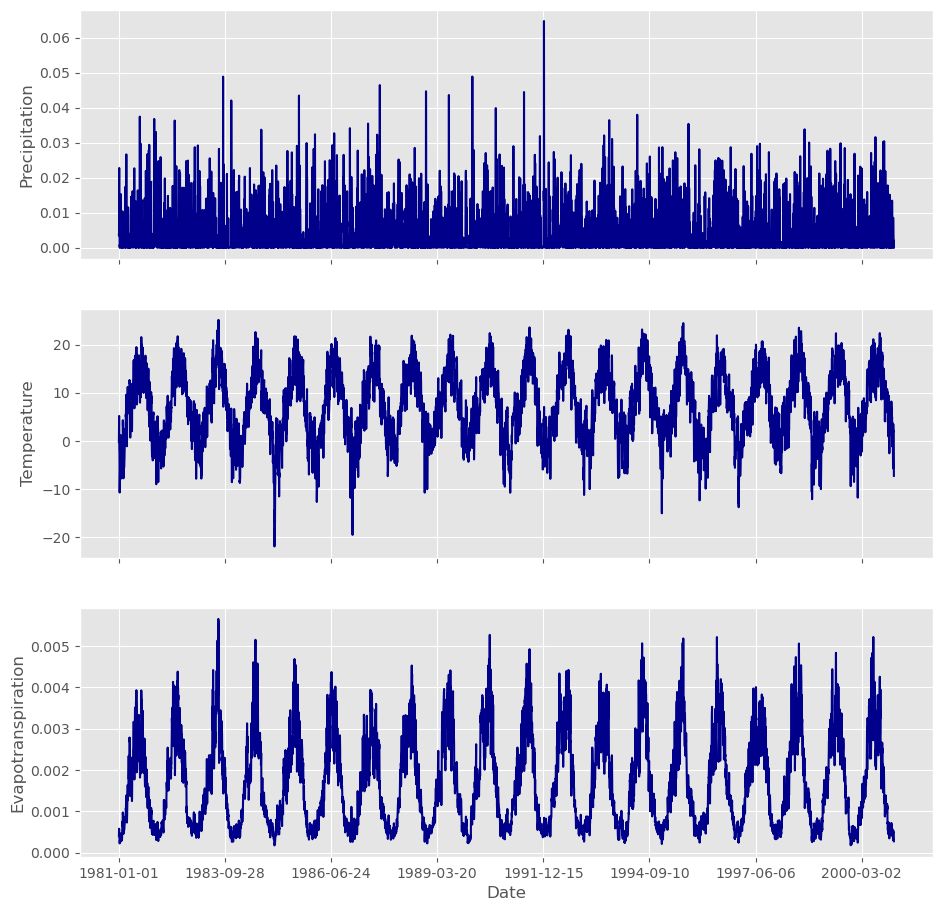

In [5]:
# Customize the style of the plot
from matplotlib import style
style.use('ggplot')

# Plot the input data
axes = input_data.plot(use_index=True, y=["p", "t", "et"], figsize=(11, 11),
                       subplots=True, sharex=True, xlabel="Date", legend=False,
                       color='darkblue')

# Add labels to the y-axes
axes[0].set_ylabel('Precipitation')
axes[1].set_ylabel('Temperature')
axes[2].set_ylabel('Evapotranspiration')

plt.show()

And now we can plot the output variable, that is, the discharge.

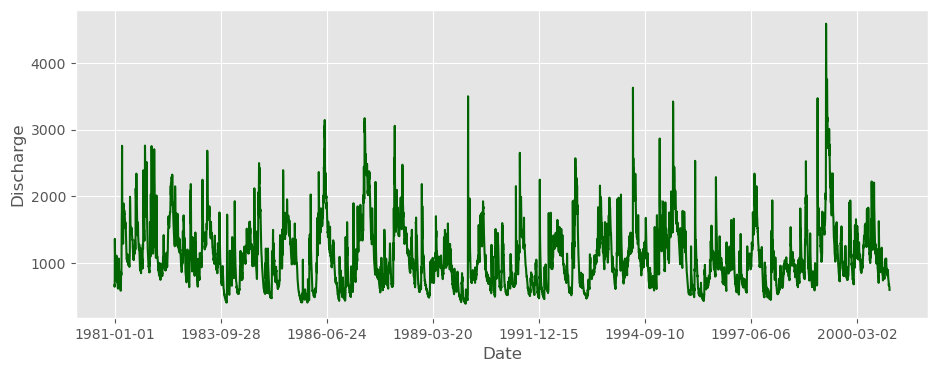

In [6]:
# Plot the output data
output_data.plot(use_index = True, y = "obs", figsize=(11, 4), xlabel = "Date",
                 ylabel="Discharge", legend = False, color = 'darkgreen')
plt.show()

Upon visual inspection, all the variables appear to be in order and consistent, following the expected seasonal trend.


## 0.3 Learning the task

### Train/test split

In machine learning, splitting the dataset into training and testing dataset is a crucial step to assess the model, as it is the only way to guarantee that we obtain a good idea of its performance on the task for unseen data.

- Training set: used to train the model, from which it can learn the non-linear relationships between depedent variable (in our case, obs) and indepedent variables (p, t, et). It should be large and diverse enough to ensure that our model learns the task well.

- Test set: used only at the very end to evaluate the model perfomance. It should not guide any choice of parameters to ensure the model generalizability to new data. It is usually smaller than the training set, but should still be representative enough.

Sometimes, the data is further split into a validation dataset, which is used to tune the model hyperparameters, but for now we will skip that part.

> **Attention**: In traditional modelling, what we define here as testing is usually referred as model validation, but in ML this term has another meaning, so be careful when using it.


There are several techniques to split the dataset into training and testing, but here we are going to use a temporal 90-10 split. The first 90% of the data will be used for training and the remaining 10% for testing. This can be automatically done by using the `train_test_split` function from the sklearn library.

The `test_size` parameter indicates the percentage of the data to use for the test set, in our case 0.1, and the `shuffle` one whether or not to randomize the data that goes into it. Because we want to predict new data rather than interpolate, we set it to false so we only take the last chunck.

In [7]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(input_data, output_data, test_size = 0.1, shuffle=False)
print(f"Train sample size is {X_train.index.size} and test sample size is {X_test.index.size}")

Train sample size is 6574 and test sample size is 731


### Model training

In sklearn we first import and initialize the type of model that we want to use, and then we use `.fit()` method on it, to train it with our data. We will use a very common ML algorithm, Random Forest, in its "regressor" version (i.e., for continuous output). The `random_state` is set to a random value to ensure reproducibility. For comparison, we also "train" a linear regression model, also included in the sklearn package, with the same syntax. A list of all models supported can be found in the sklearn website (https://scikit-learn.org/).

To "learn", ML models change their internal parameters to optimize what we call the loss function, corresponding to the `criterion` parameter. We are using `squared_error`, meaning that we try to minimize the mean squared error between the model predictions and the observations of our output variable. We could also change other characteristics of the model, also called hyperparameters, to achieve maximum perfomance. This is commonly known as hyperparameter tuning. Keep posted for a coming workshop on the topic! For now, we will keep the default values.

In [26]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=10, criterion='squared_error')
rf_model.fit(X_train, y_train.values.ravel())

# Train a Linear Regression model
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train.values.ravel());

## 0.4 Evaluating the model

### Predicting the test data

Now that we have already trained our models, we can make a prediction for any new data points. We will go ahead and make our predictions on the test input data, which we have not used so far to obtain an unbiased estimate of our model's performance.

In [27]:
# Predict the test data using both models
rf_prediction = rf_model.predict(X_test)
lin_prediction = lin_model.predict(X_test)

Let's visualize these predictions against the observed values, which are stored in the `y_test` variable. This can already gives us a good idea of the model's performance.

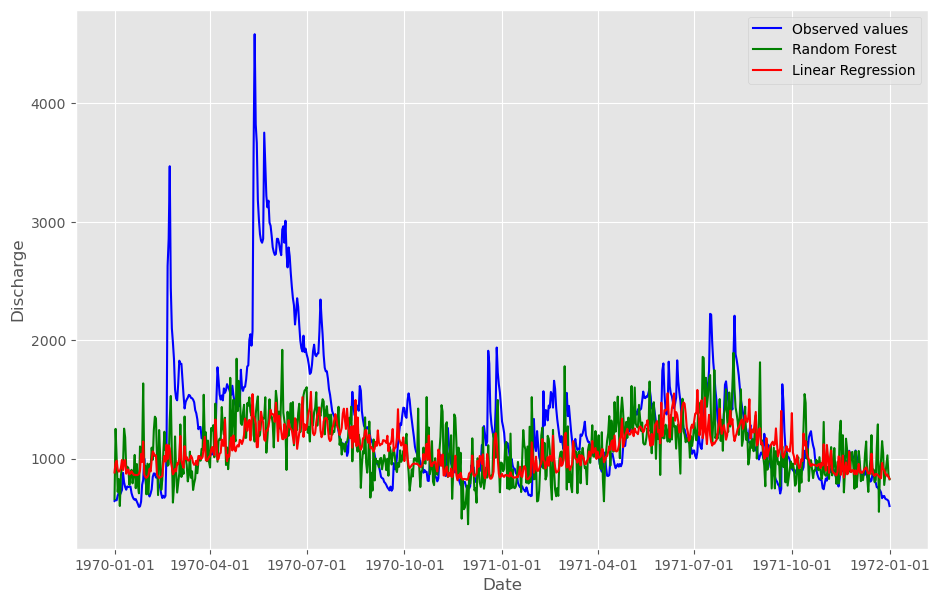

In [28]:
plt.figure(figsize=(11, 7))

# Plot the predictions and observed values
plt.plot(y_test.index, y_test, label='Observed values', color='b')
plt.plot(y_test.index, rf_prediction, label='Random Forest', color='g')
plt.plot(y_test.index, lin_prediction, label='Linear Regression', color='r')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.legend()

# Customize the x-axis to show the dates
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

Because we have a relatively small dataset we are able to plot our results, but this is rarely the case. Even more, from just this plot it is not immediately obvious which model is performing best. Therefore, we usually we need to resort to metrics for evaluating our models.

### Checking the metrics

To compare the performance of our RF model with the linear regression, we are going to use a few common metrics: R squared, mean absolute error (MAE) and mean squared error (MSE). Remember that for the R squared higher is better, but for the rest it is the opposite.

We could define them ourselves, but since these metrics are commonly used we can directly import them from `sklearn.metrics`. We finally compile the results in a nice pandas Dataframe for visualization purposes.

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate metrics for Random Forest
rf_r2 = r2_score(y_test, rf_prediction)
rf_mae = mean_absolute_error(y_test, rf_prediction)
rf_rmse = mean_squared_error(y_test, rf_prediction, squared=False)

# Calculate metrics for Linear Regression
lin_r2 = r2_score(y_test, lin_prediction)
lin_mae = mean_absolute_error(y_test, lin_prediction)
lin_rmse = mean_squared_error(y_test, lin_prediction, squared=False)

# Create DataFrame to store the metrics
metrics = pd.DataFrame({
    'R²': [lin_r2, rf_r2],
    'MAE': [lin_mae, rf_mae],
    'RMSE': [lin_rmse, rf_rmse]
}, index=['Linear Regression', 'Random Forest'])

# Round to different number of decimal places for each column
metrics = metrics.round({'R²': 4, 'MAE': 1, 'RMSE': 1})
metrics

,R²,MAE,RMSE
Linear Regression,0.0670,331.5,536.1
Random Forest,0.0732,345.0,534.3


Both R squared and RMSE indicate that our Random Forest model is performing slightly better than a simple linear regression but it has a worse MAE. This may indicate that our Random Forest model is doing slightly worse on average, but better manages to avoid really high errors, which are heavily penalized by the MSE and R squared metrics.

From these results, we cannot say that the RF model is doing significantly better than the linear alternative. Let's try to see what is going wrong in our model by using some more plots.

### Predicted vs Actual plot

A scatter plot of Predicted vs Actual output values offers a lot of information on how our model is performing. In an ideal model, all points would be at the diagonal line, for which the predicted and actual values are the same. The further away from the line, the bigger the error. Points above the diagonal line indicate that the model is overestimating, and below it that it is underestimating.

It is very easy to make such a plot using matplotlib. Make sure to also plot the diagonal!

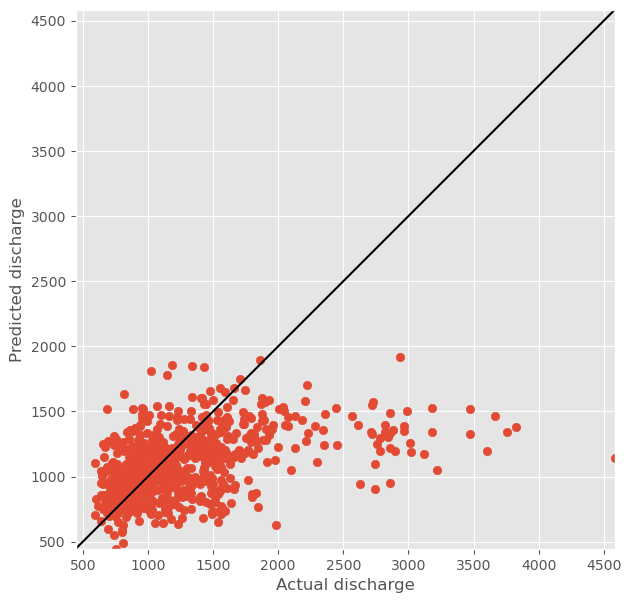

In [33]:
plt.figure(figsize=(7,7))

# Plot the observed vs predicted values
plt.scatter(y_test, rf_prediction)

# Plot the diagonal line
min_val = min(min(y_test.values), min(rf_prediction))
max_val = max(max(y_test.values), max(rf_prediction))
plt.plot([min_val, max_val], [min_val, max_val], color='black')

# Add labels
plt.xlabel('Actual discharge')
plt.ylabel('Predicted discharge')

# Set the aspect of the plot to be equal
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

It is quite clear from this plot that our model really struggles to predict the high discharge measurements, which it consistently underestimates. Additionally, the fact that most points are in a relatively thick cloud around from the diagonal line indicates that it is not a very precise model, even for lower discharge values.

## 0.5 Final remarks

Wait, what, that's it? All of this fuzz about ML models and now it even struggles to do a simple task? Well, of course not! This was just a tutorial to train your first ML model, you cannot expect it to have an amazing performance out of the box. There are many more tricks that we can do on the data and the model itself to improve our performance, so keep posted for more workshops!  :)

For now, why don't you try to fit another model from the *scikit-learn* library? What about a neural network for example? You will first need to import the [*MLPRegressor*](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor) from `sklearn.neural_network`. Now is your time to code, copy-paste and adapt the code in the previous sections as necessary to train your first ever ML model!

In [ ]:
# Define and fit the model


# Make predictions


# Plot the results
